# NEXUS tool: case study for the Jordan - energy demand calculations
In this notebook a case study for the Jordan country is covered using the `nexus_tool` package. The water requirements for agricultural irrigation, residential, industrial and tourism use were previously calculated using the Water Evaluation and Planning System (WEAP) model. In this case study, the energy requirements for groundwater pumping, wastewater treatment, desalination of seawater and pumping for water conveyance are estimated.

First import the package by running the following block:

In [2]:
%load_ext autoreload

In [3]:
%autoreload
import sys
sys.path.append("..") #this is to add the avobe folder to the package directory
import os
import nexus_tool
from nexus_tool.weap_tools import create_folder
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
# scenarios = ['Reference', 'Improve AG eff', 'New Resources', 'Reduce NRW']
scenarios = ['Reference']
load_folder = os.path.join('Data', 'WEAP Results', 'Processed data')
results_folder = os.path.join('../Jordan dashboard', 'data')
for scenario in scenarios:
    scenario_folder = os.path.join(load_folder, scenario)
    create_folder(os.path.join(results_folder, scenario))
    for sub_scenario in os.listdir(scenario_folder):
        sub_scenario_folder = os.path.join(scenario_folder, sub_scenario)
        create_folder(os.path.join(results_folder, scenario, sub_scenario))
        for level in os.listdir(sub_scenario_folder):
            output_folder = os.path.join(results_folder, scenario, sub_scenario, level)
            load_data = os.path.join(sub_scenario_folder, level)
            create_folder(output_folder)
    
            file_path = os.path.join(load_data, 'Pipelines_flow.csv')
            df = nexus_tool.read_csv(file_path)

            jordan = nexus_tool.Model(df)
            jordan.df['Pipe_diameter'] = 1 #in m
            jordan.df.loc[(df['pipeline']=='KAC'), 'Pipe_diameter'] = 4 #in m
            jordan.df.loc[(df['pipeline']=='PL_Disi'), 'Pipe_diameter'] = 1.4 #in m
            jordan.df.loc[(df['pipeline']=='PL_RedDead'), 'Pipe_diameter'] = 1.4 #in m
            jordan.df.loc[(df['pipeline']=='PS_ZaraMain'), 'Pipe_diameter'] = 1.8 #in m
            jordan.df.loc[(df['pipeline']=='PL_KACToZay'), 'Pipe_diameter'] = 1.4 #in m
            jordan.df.loc[(df['pipeline']=='PL_Dab_AinGhazal'), 'Pipe_diameter'] = 1.4 #in m
            jordan.df.loc[(df['pipeline']=='PL_ZaytoDabouq'), 'Pipe_diameter'] = 1.4 #in m

            jordan.elevation = 'elevation_delta'
            jordan.L = 'segment_length'
            jordan.peak_Q = 'value'
            jordan.avg_Q = 'value'
            jordan.SWpump_eff = 1 # pumping efficiency

            jordan.get_A(inplace=True)
            jordan.get_V(inplace=True, axis=0)
            jordan.get_Re(inplace=True, axis=0)
            jordan.get_f(inplace=True, axis=0)

            jordan.get_sw_tdh(inplace = True, axis=0)

            jordan.get_SWpumping_energy(inplace = True, axis=0)

            jordan.df['Q_per_meter_seg'] = jordan.df.value * jordan.df.segment_length / jordan.df.pipeline_length
            _vec = jordan.df.groupby(['Year','Month','pipeline'])['Q_per_meter_seg'].sum()
            jordan.df['Q_per_meter_pl'] = jordan.df.set_index(['Year', 'Month', 'pipeline']).index.map(_vec)

            file_path = os.path.join(load_data, 'Required_demand.csv')
            df_required = pd.read_csv(file_path)

            file_path = os.path.join(load_data, 'Delivered_demand.csv')
            df_delivered = pd.read_csv(file_path)

            file_path = os.path.join(load_data, 'Groundwater_supply.csv')
            df_groundwater = pd.read_csv(file_path)

            jordan_gw = nexus_tool.Model(df_groundwater)
            jordan_gw.df['Pipe_diameter'] = 0.4

            jordan_gw.elevation = 'wtd'
            jordan_gw.L = 'wtd'
            jordan_gw.peak_Q = 'value'
            jordan_gw.avg_Q = 'value'

            jordan_gw.get_A(inplace=True)
            jordan_gw.get_V(inplace=True, axis=0)
            jordan_gw.get_Re(inplace=True, axis=0)
            jordan_gw.get_f(inplace=True, axis=0)

            jordan_gw.get_sw_tdh(inplace = True, axis=0)
            jordan_gw.get_SWpumping_energy(inplace = True, axis=0)

            file_path = os.path.join(load_data, 'WWTP_inflow.csv')
            df_wwtp = pd.read_csv(file_path)

            wwtp_energy_int = 0.6 # kWh/m3
            df_wwtp['SWPA_E_'] = df_wwtp.value * wwtp_energy_int
            
            file_path = os.path.join(load_data, 'Desalination.csv')
            df_desal = pd.read_csv(file_path)

            red_dead_energy_int = 3.31 # kWh/m3
            aqaba_energy_int = 5 # kWh/m3
            df_desal['SWPA_E_'] = 0
            df_desal.loc[df_desal.point=='RedDead', 'SWPA_E_'] = df_desal.loc[df_desal.point=='RedDead', 'value'] * red_dead_energy_int
            df_desal.loc[df_desal.point=='Aqaba Desal', 'SWPA_E_'] = df_desal.loc[df_desal.point=='Aqaba Desal', 'value'] * aqaba_energy_int

            jordan.df.loc[jordan.df.Year>=2020].to_csv(os.path.join(output_folder, 'Pipelines_data.csv'), index=False)
            df_required.loc[df_required.Year>=2020].to_csv(os.path.join(output_folder, 'Water_requirements.csv'), index=False)
            df_delivered.loc[df_delivered.Year>=2020].to_csv(os.path.join(output_folder, 'Water_delivered.csv'), index=False)
            jordan_gw.df.loc[jordan_gw.df.Year>=2020].to_csv(os.path.join(output_folder, 'Groundwater_pumping.csv'), index=False)
            df_wwtp.loc[df_wwtp.Year>=2020].to_csv(os.path.join(output_folder, 'wwtp_data.csv'), index=False)
            df_desal.loc[df_desal.Year>=2020].to_csv(os.path.join(output_folder, 'desal_data.csv'), index=False)

C:\Users\camilorg\AppData\Local\Continuum\anaconda3\envs\geoenv\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


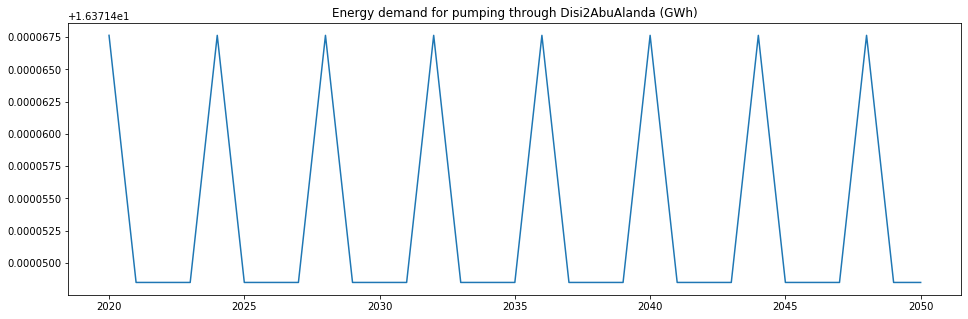

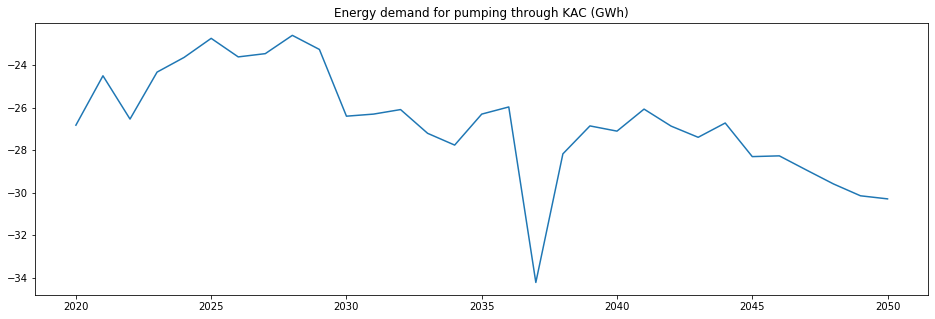

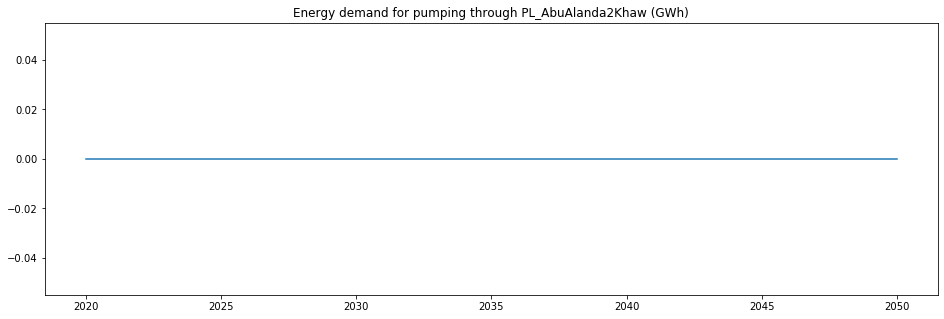

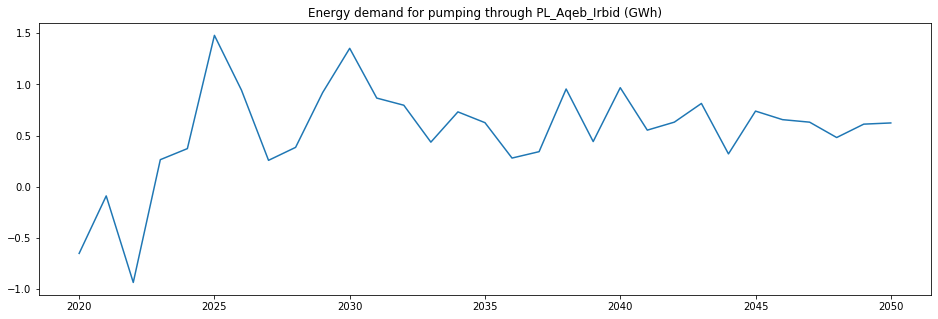

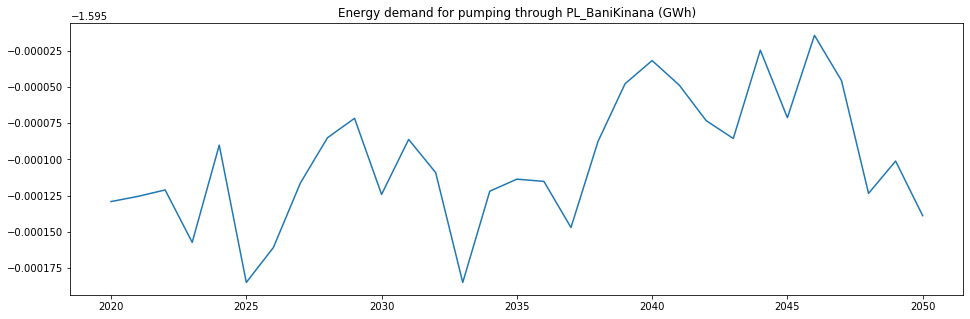

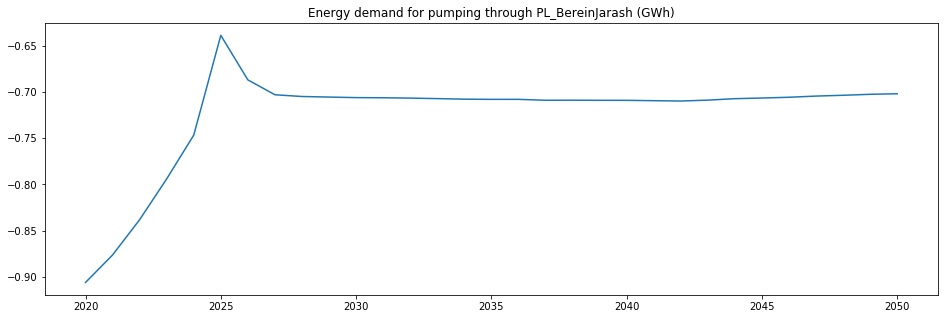

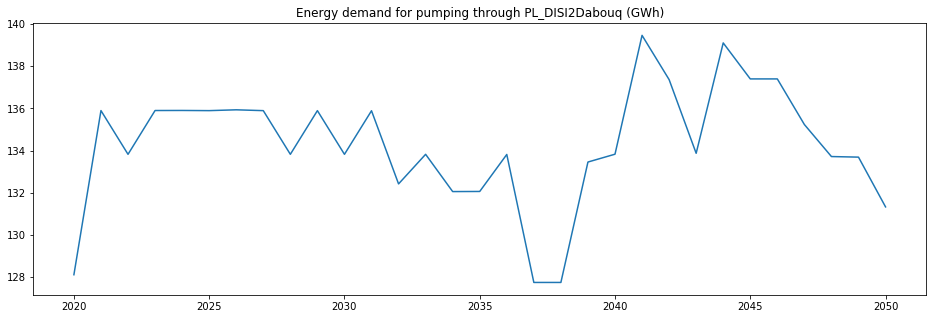

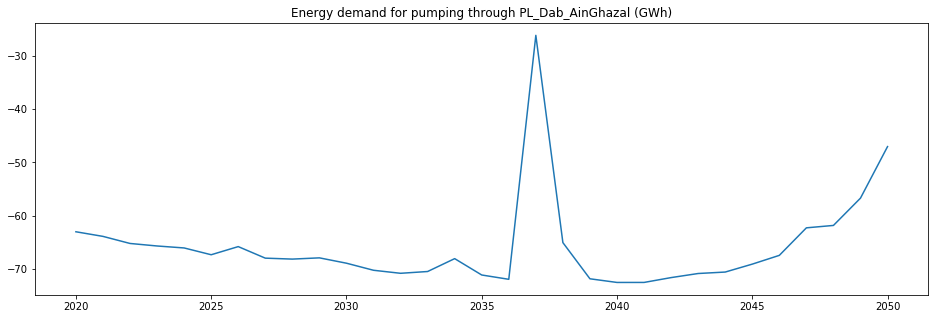

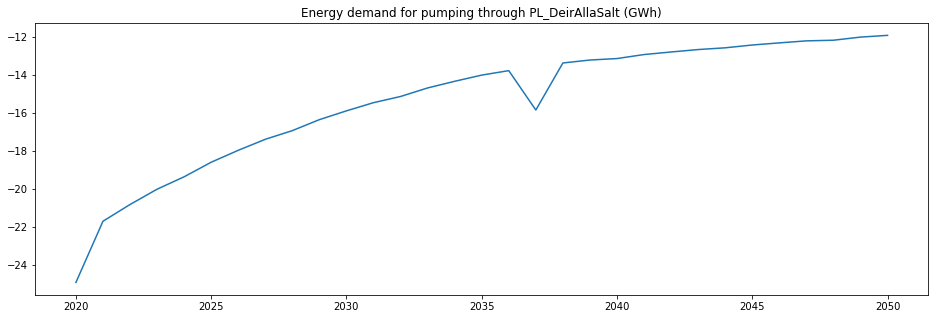

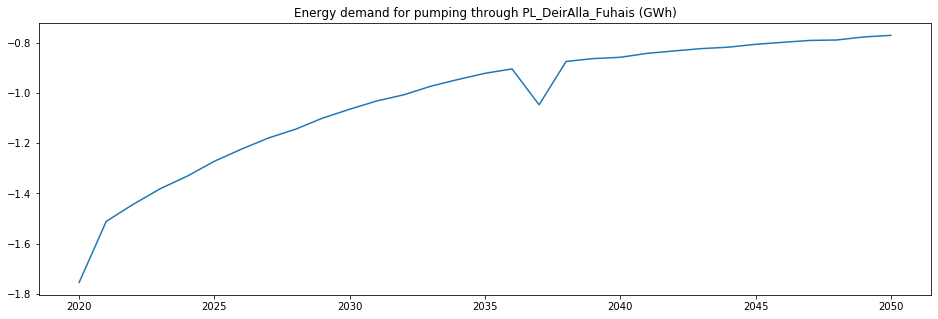

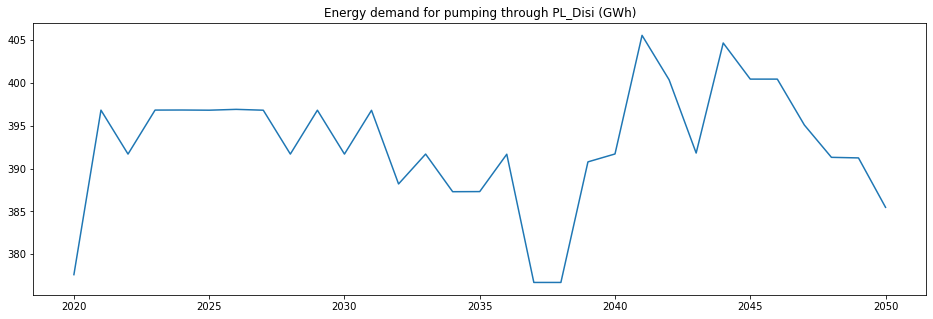

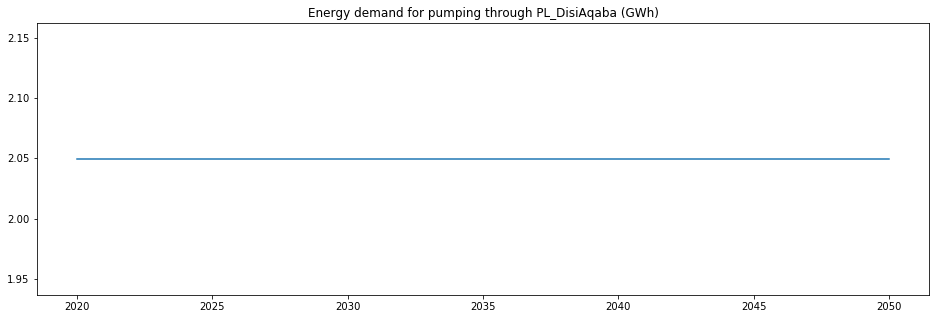

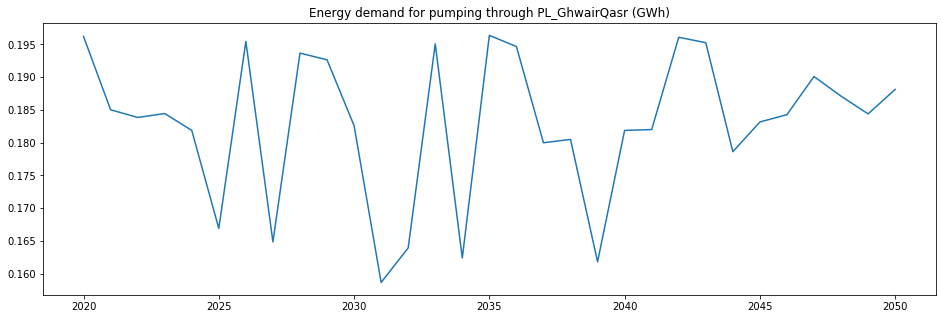

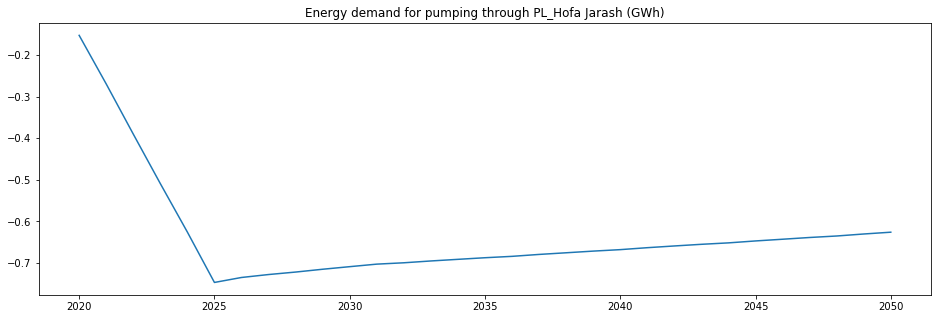

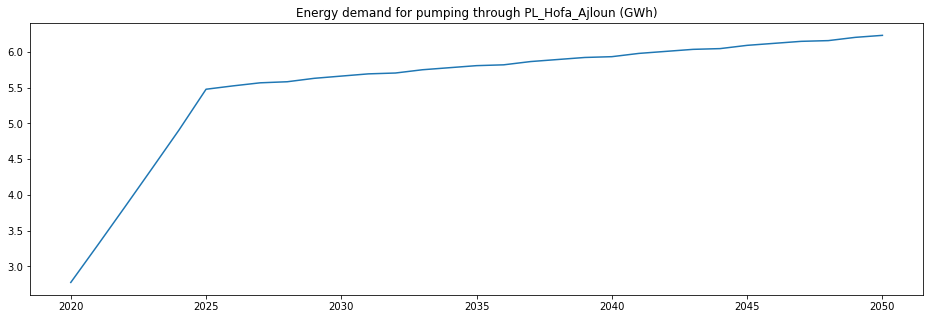

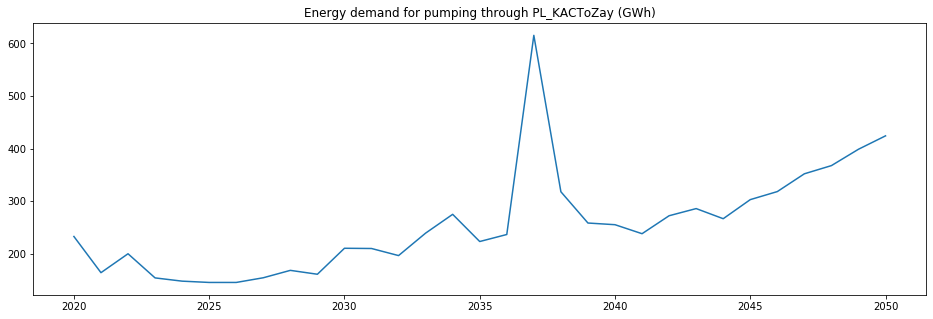

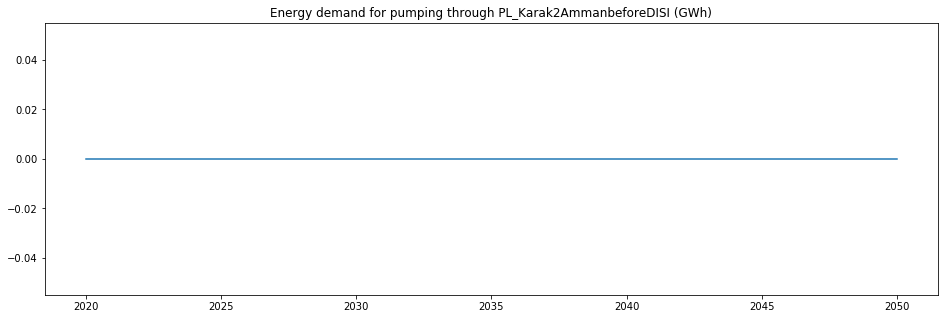

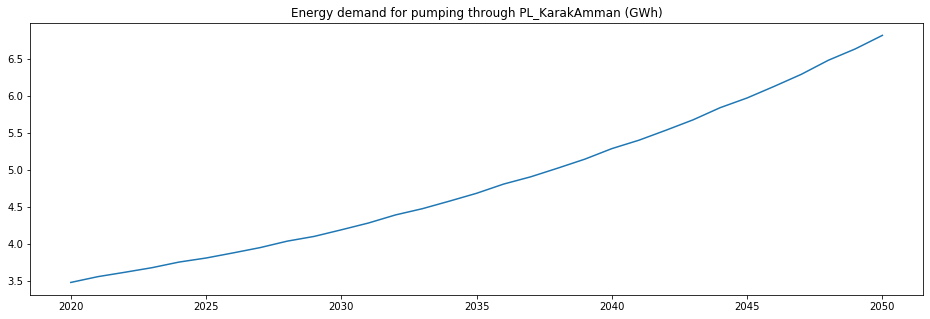

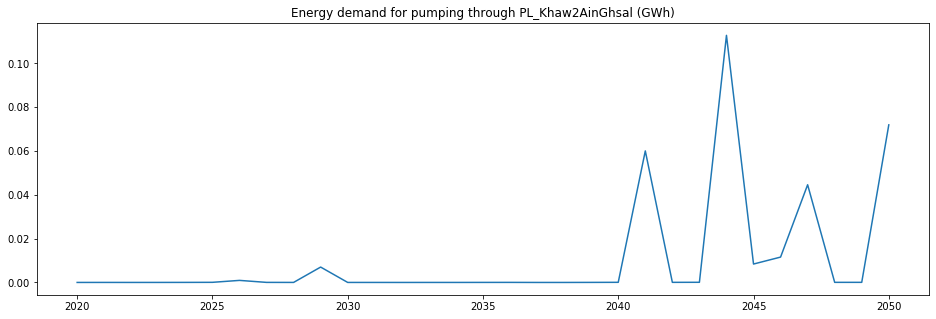

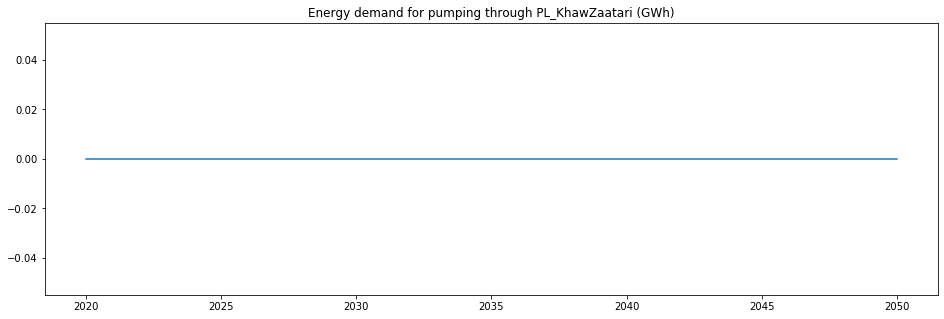

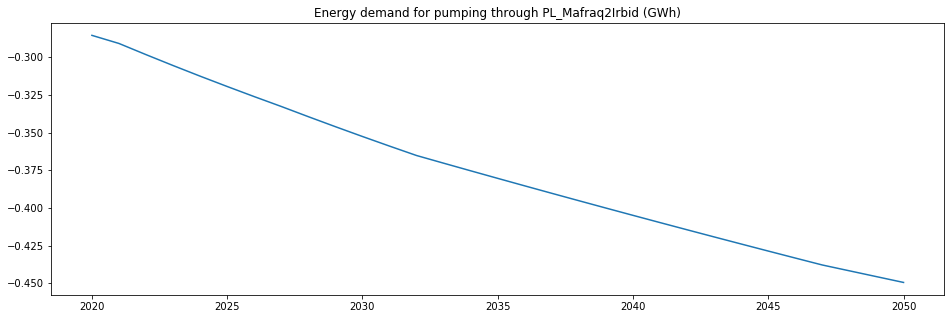

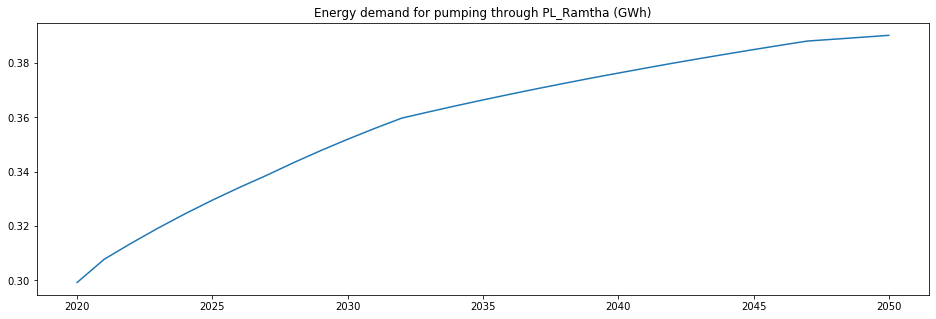

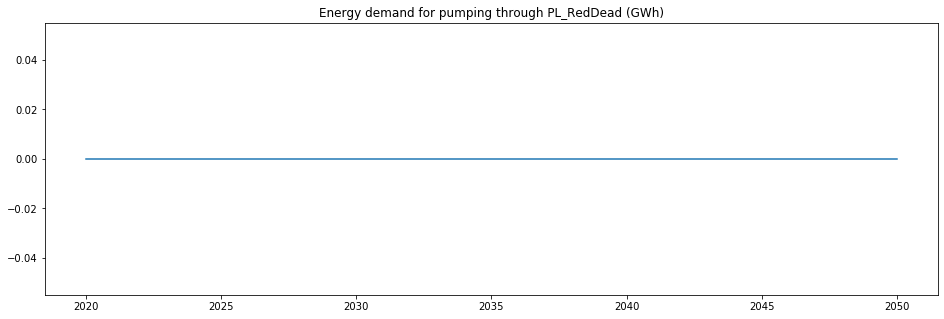

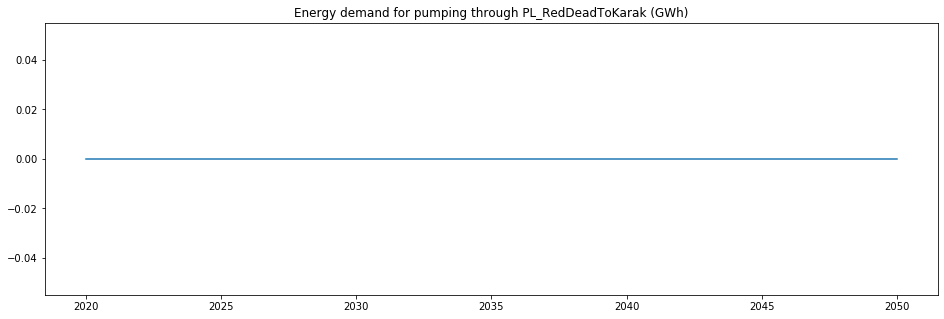

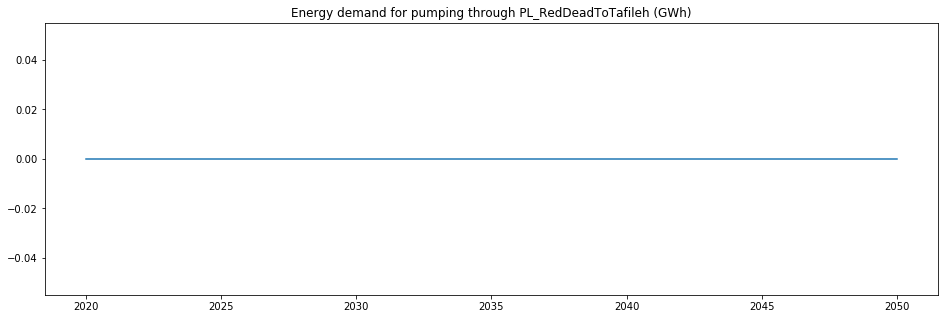

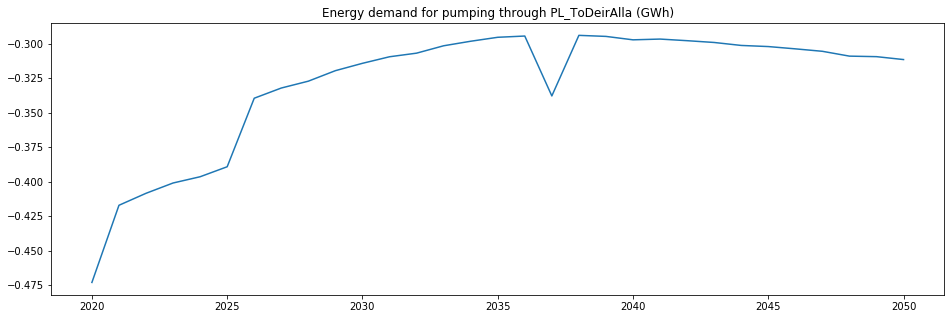

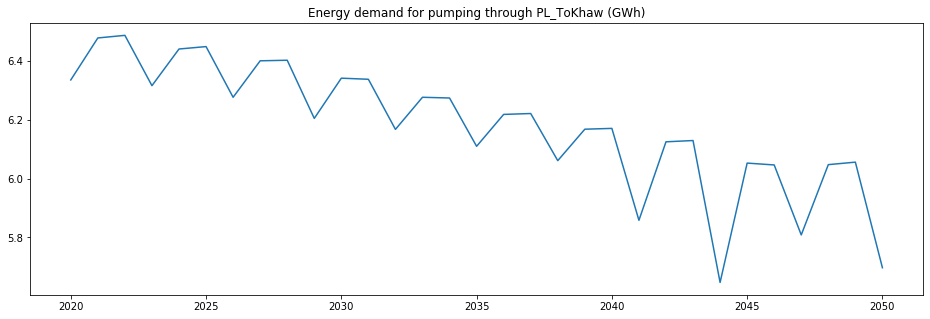

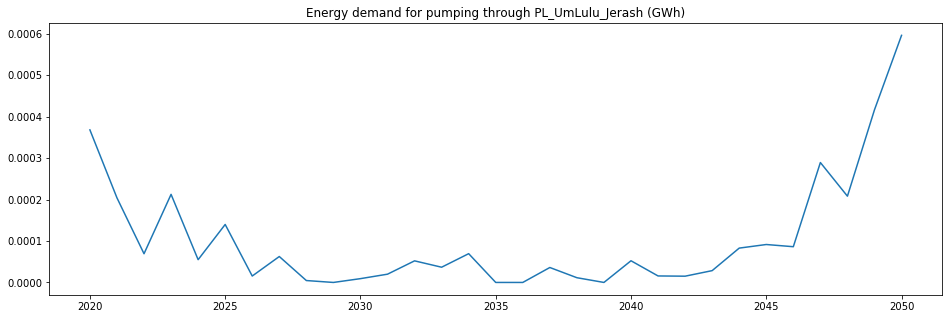

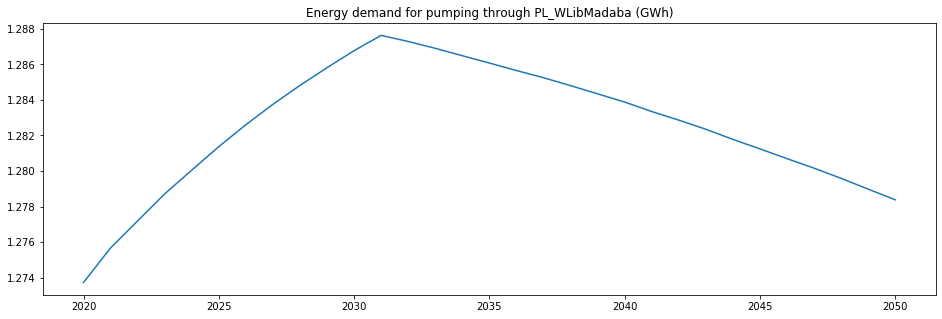

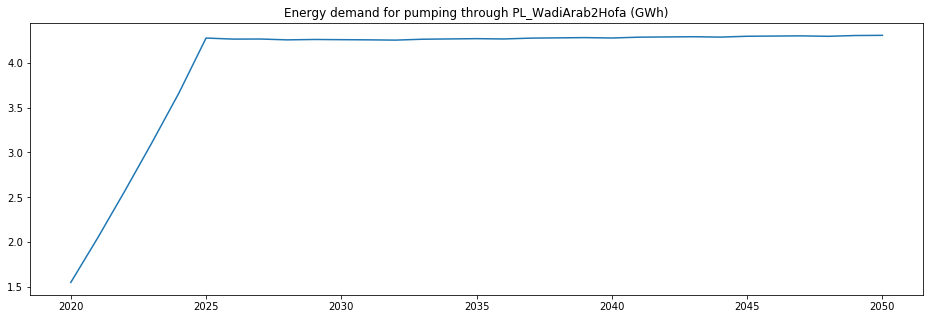

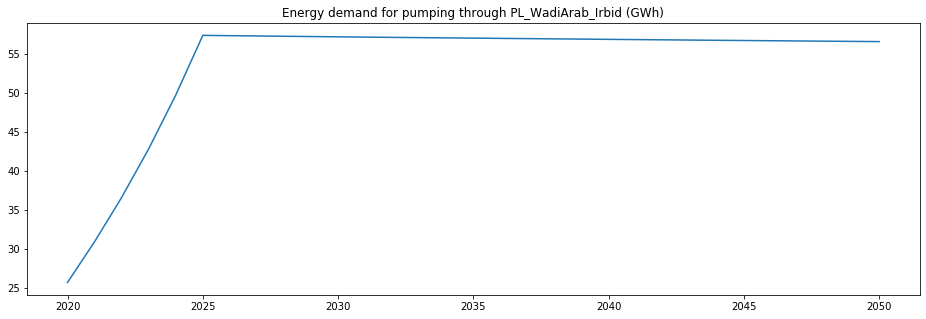

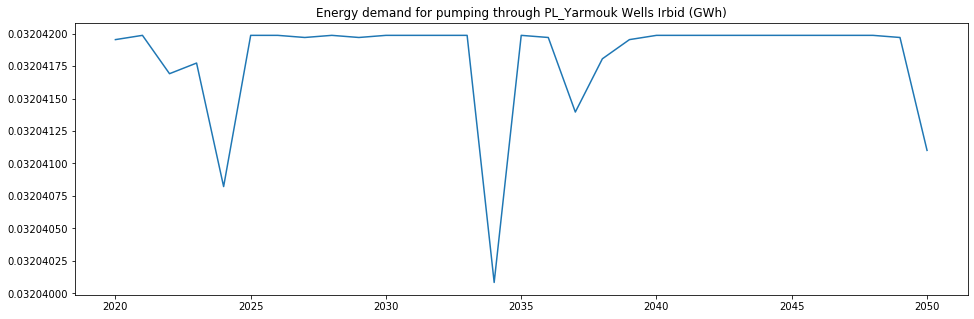

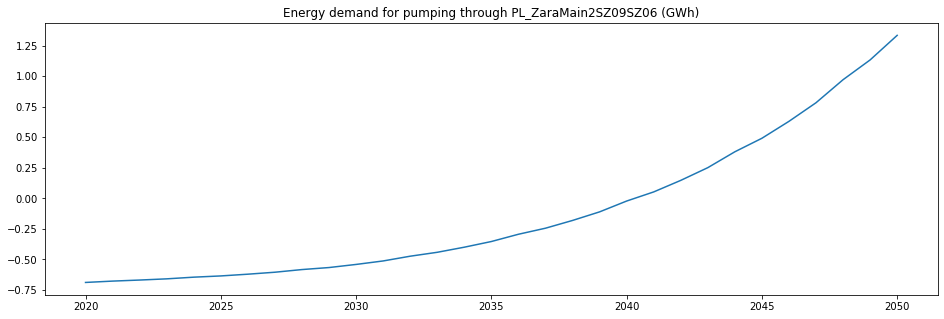

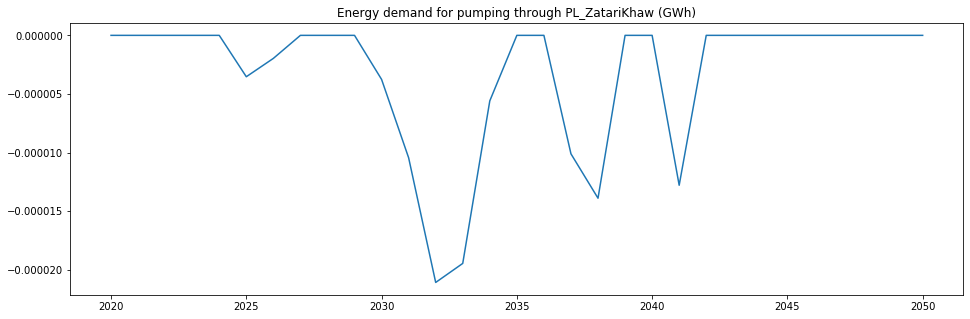

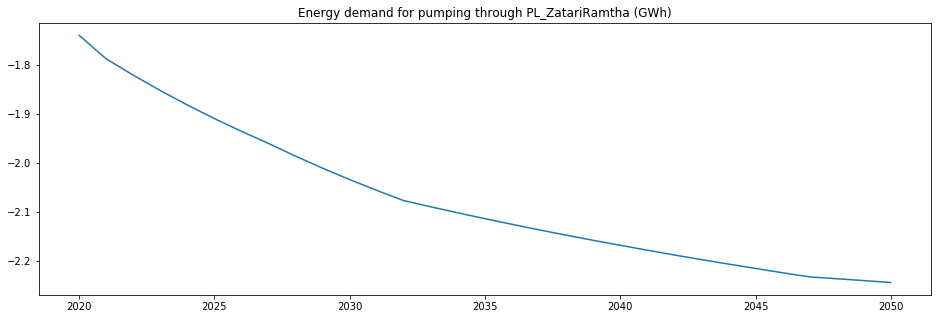

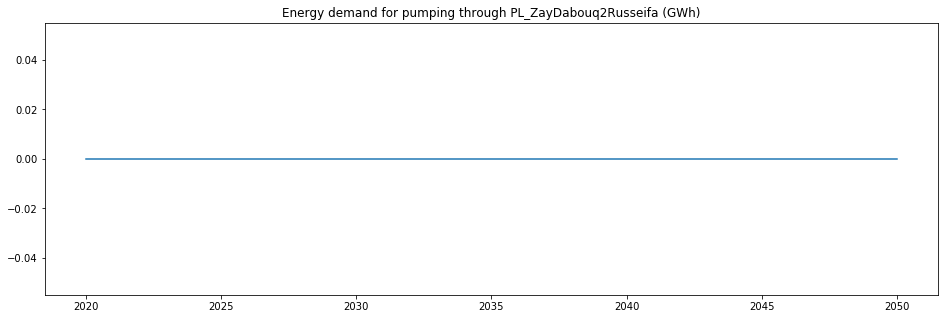

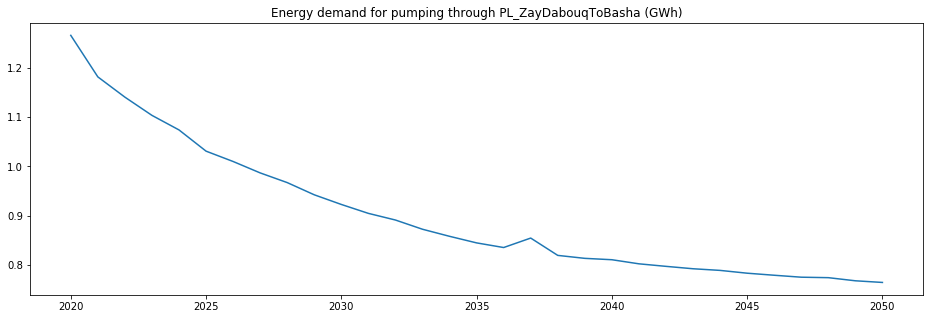

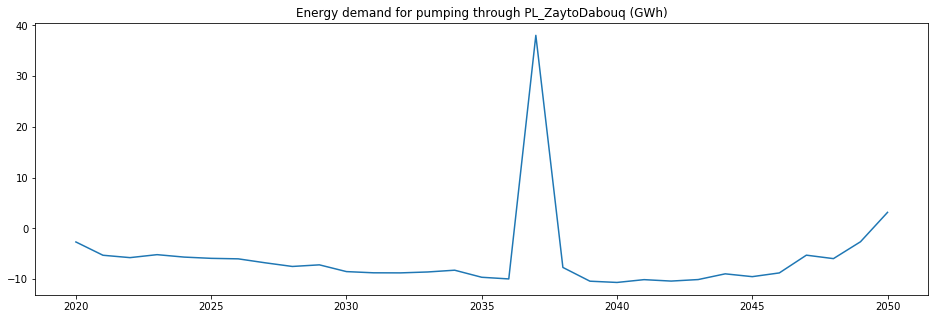

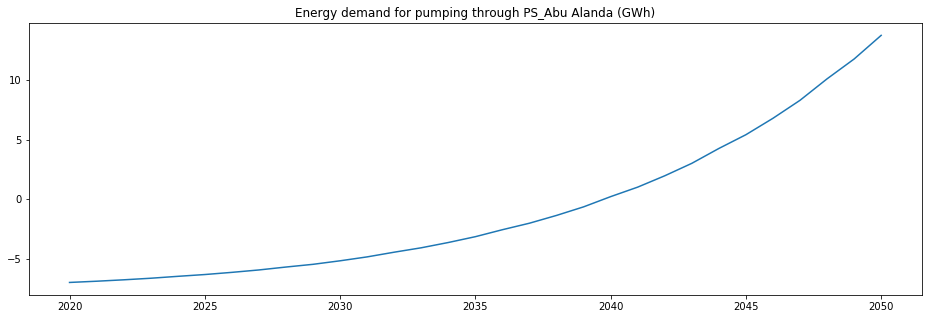

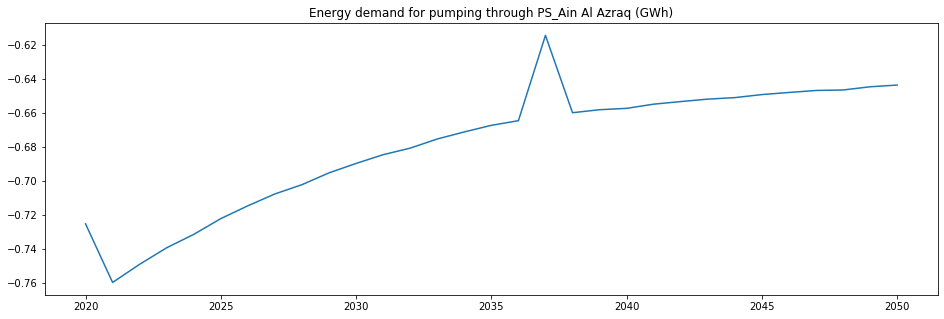

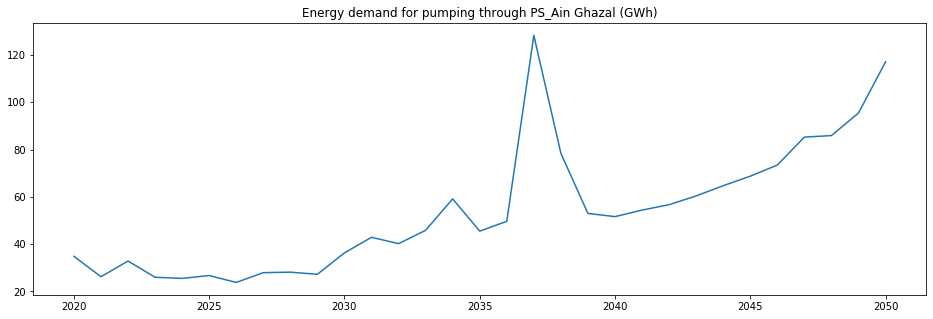

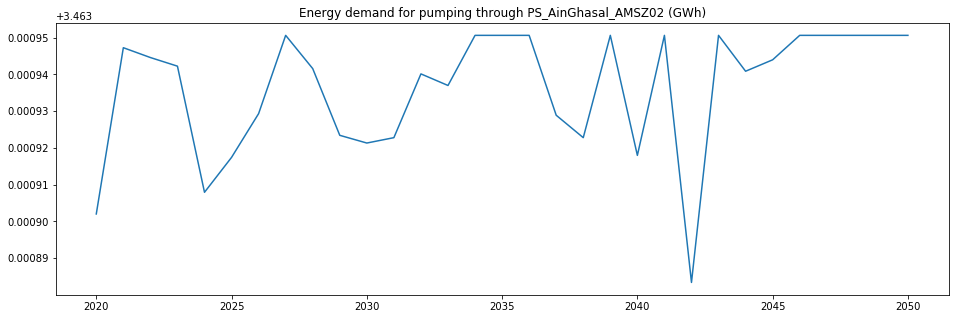

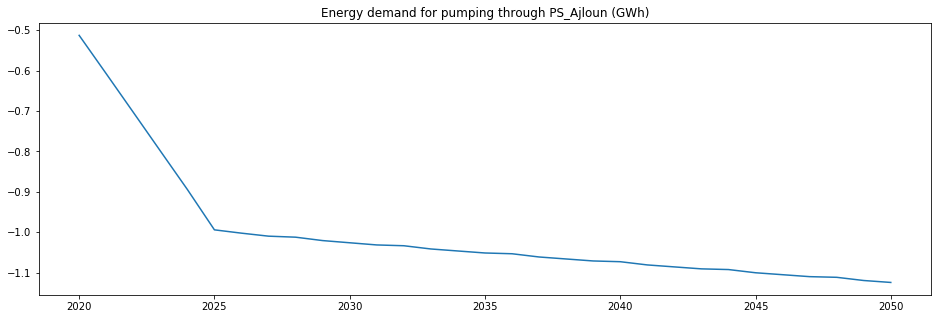

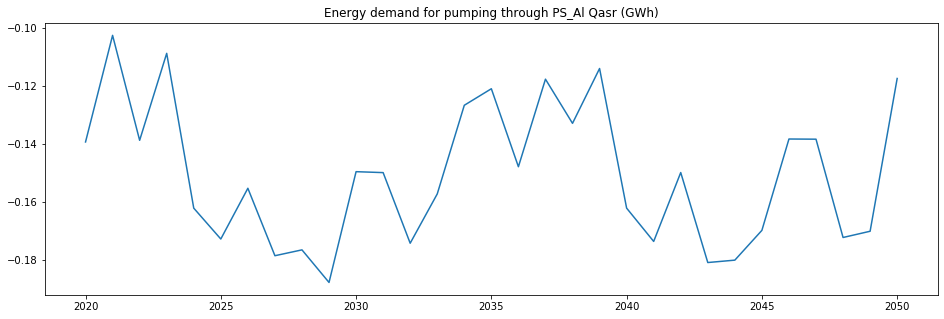

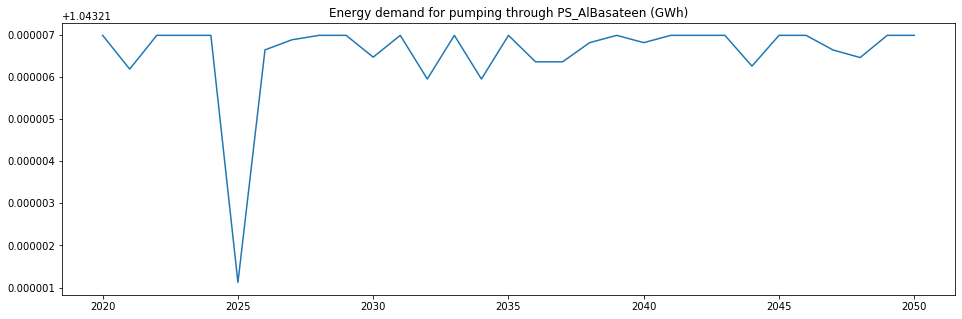

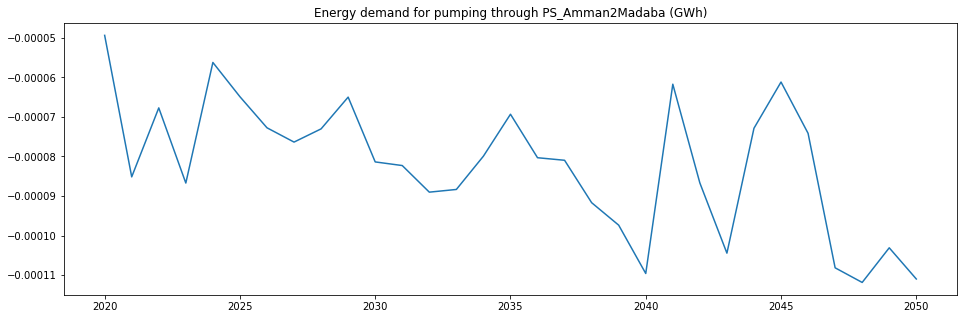

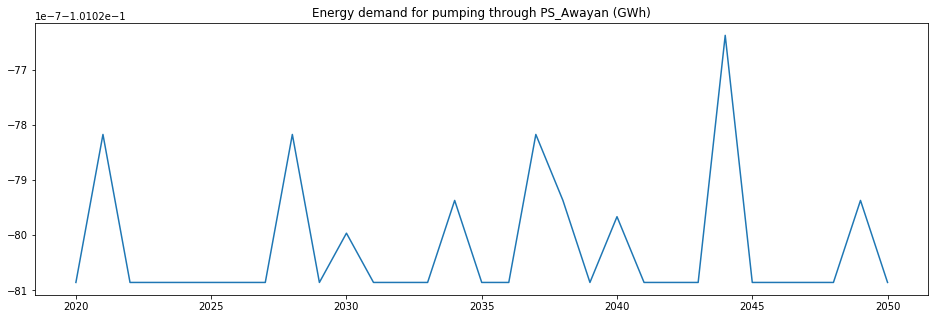

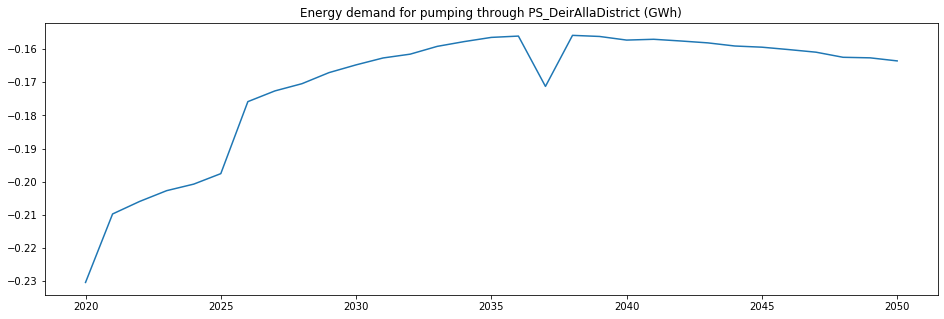

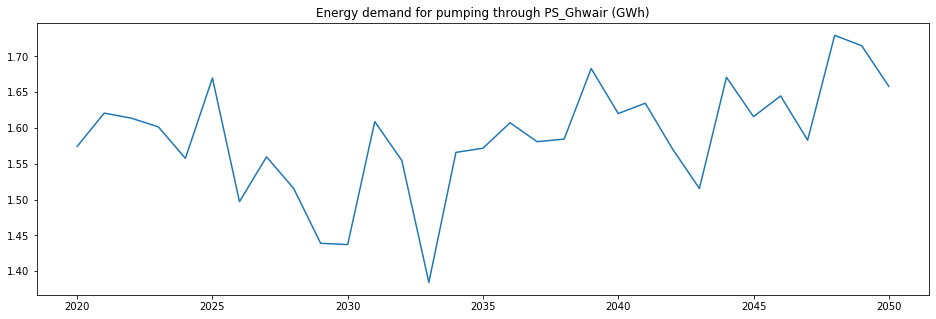

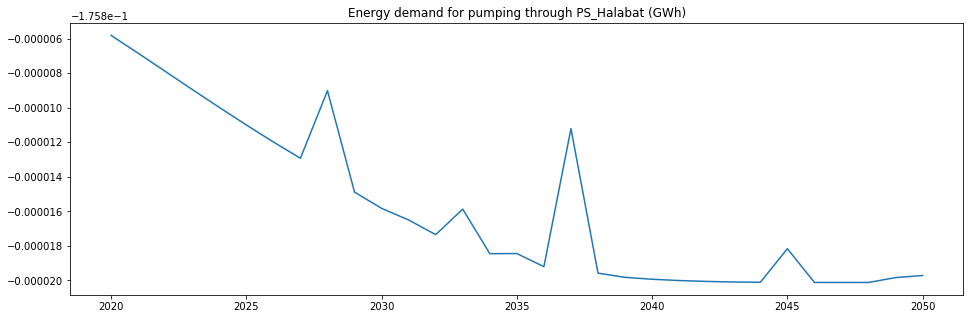

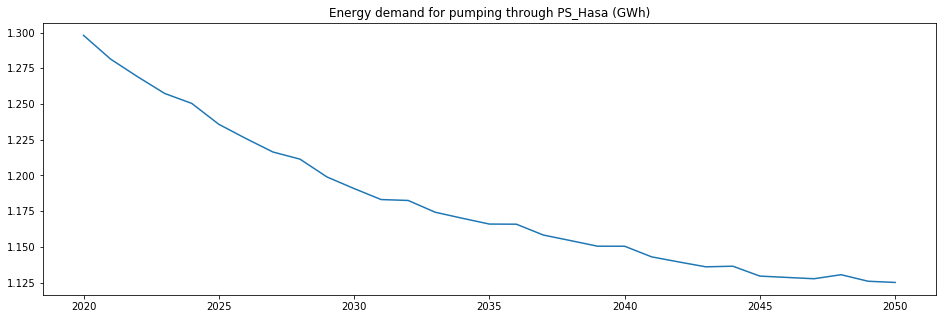

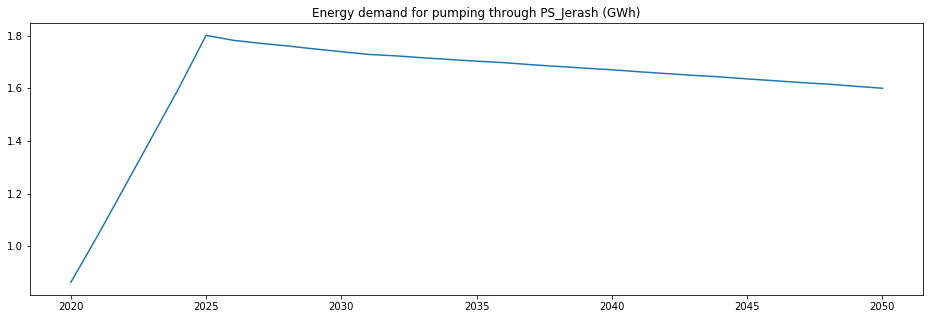

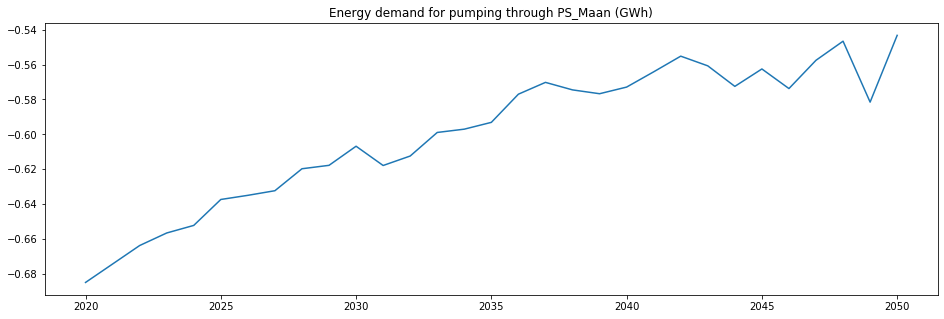

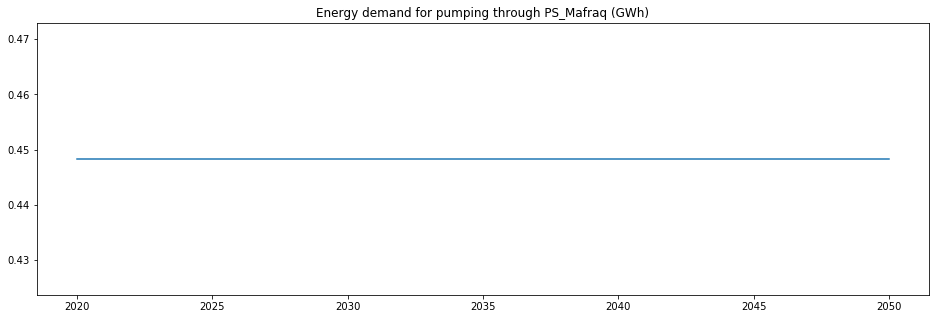

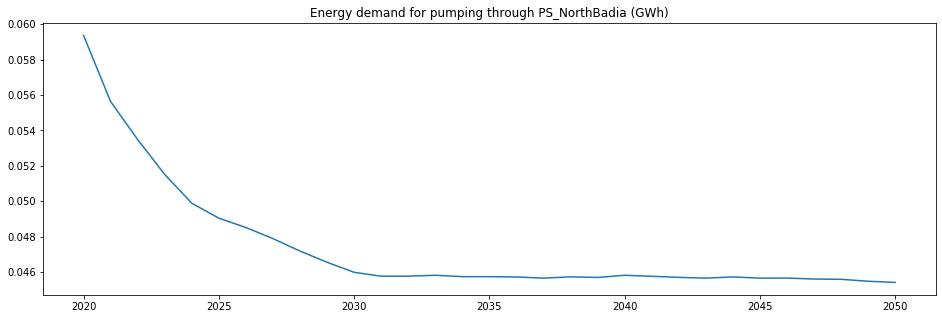

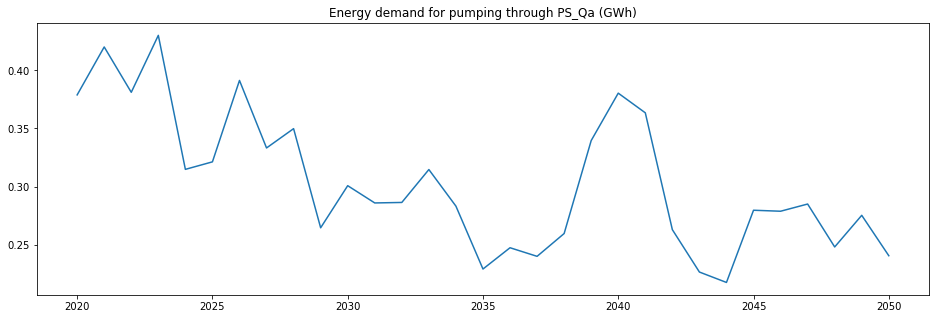

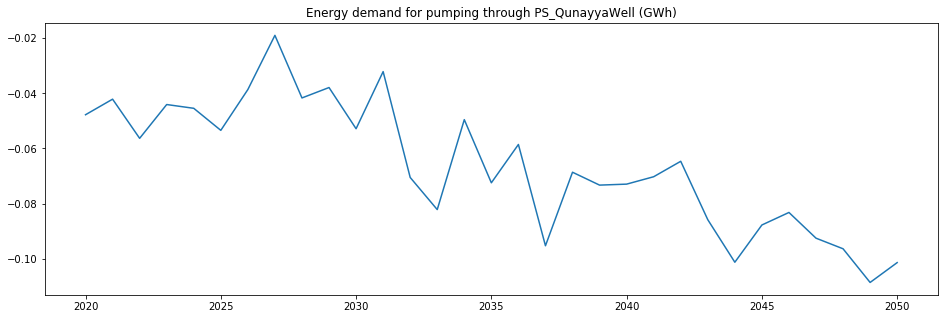

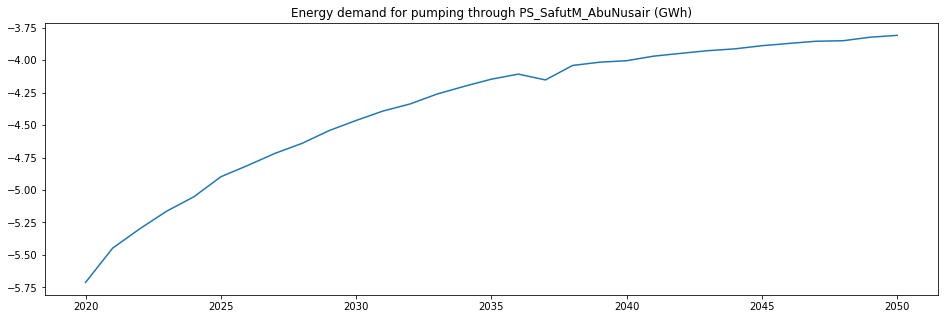

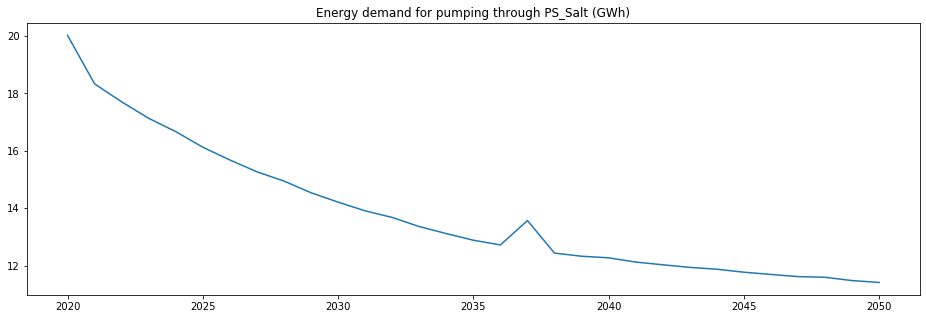

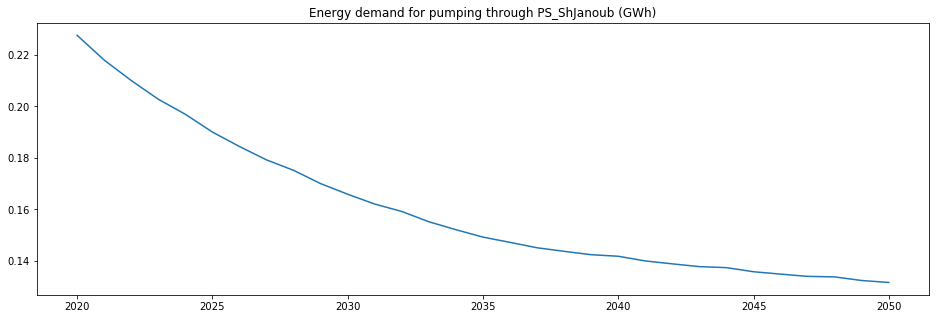

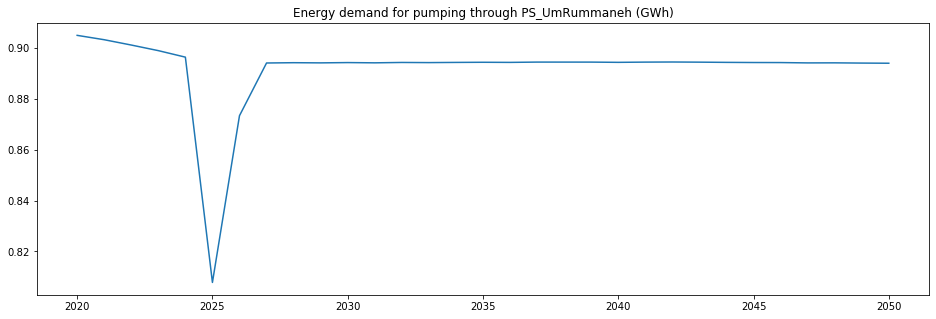

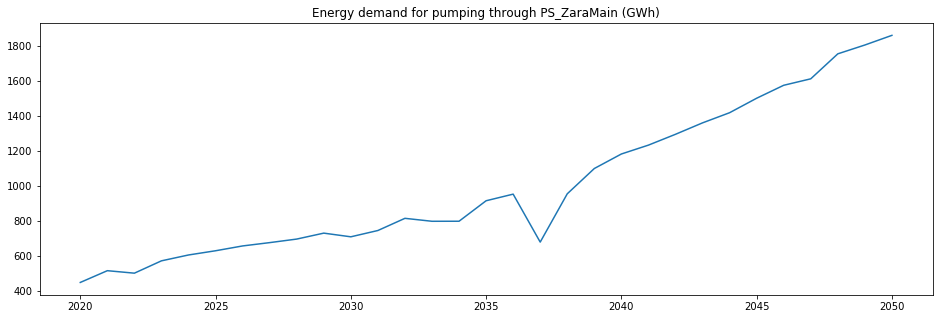

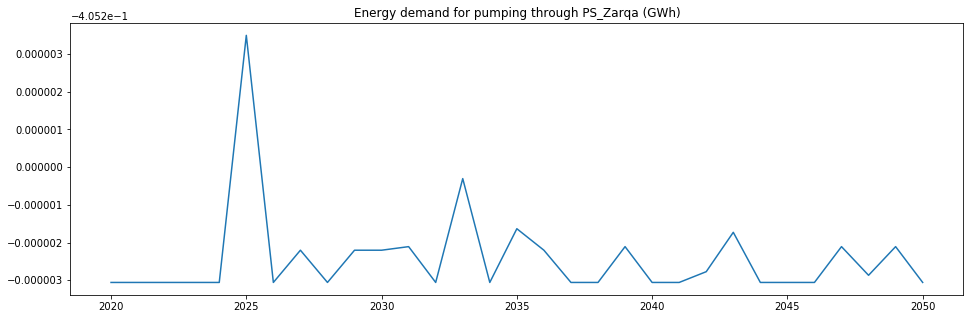

In [14]:
df = jordan.df.groupby(['Year', 'pipeline']).sum().reset_index()
for pipe in df.pipeline.unique():
    dff = df.loc[(df.pipeline==pipe)]
    plt.figure(figsize=(16,5))
    plt.title(f'Energy demand for pumping through {pipe} (GWh)')
    plt.plot(dff.Year, dff.SWPA_E_/1000000)